In [1]:
from pathinit import *



import numpy as np

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
#from jax.ops import index, index_update
jax.config.update("jax_enable_x64", True)

from functools import partial


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18
mpl.rcParams["font.family"] = "Times New Roman"

In [2]:
if jax.__version__ < '0.2.26':
    clear_cache = jax.interpreters.xla._xla_callable.cache_clear
else:
    clear_cache = jax._src.dispatch._xla_callable.cache_clear

# Example de l'usage de l'auto-diff et vectorisation

In [3]:
def f(x):
    return jnp.exp(-x*0.5)*jnp.sin(x)

In [4]:
def fp(x):
    return jnp.exp(-x*0.5)*(2.*jnp.cos(x)-jnp.sin(x))/2.
def fpp(x):
    return -jnp.exp(-x*0.5)*(4.*jnp.cos(x)+3.*jnp.sin(x))/4.

In [5]:
jfp  = grad(f)
jfpp = grad(grad(f))

In [6]:
#jax.make_jaxpr(jfp)(0.)

In [7]:
jfp = vmap(grad(f))          # besion de vectorisation pour appeler avec un array
jfpp = vmap(grad(grad(f)))

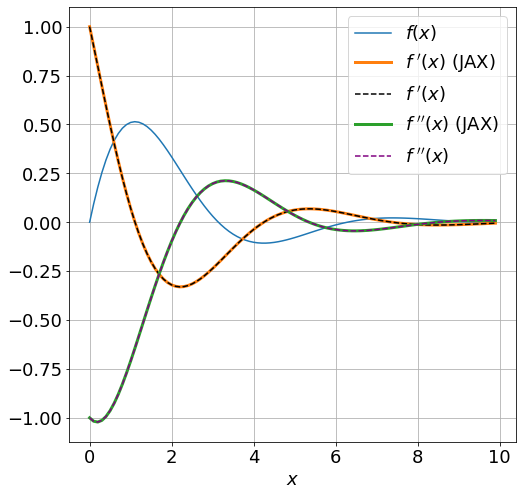

In [8]:
fig,_ = plt.subplots(figsize=(8,8))
x=jnp.arange(0,10,0.1)
plt.plot(x,f(x), label="$f(x)$")
plt.plot(x,jfp(x), lw=3,label="$f^{\ \prime}(x)$ (JAX)")
plt.plot(x,fp(x),ls="--",c='k', label="$f^{\ \prime}(x)$")
plt.plot(x,jfpp(x), lw=3,label="$f^{\ \prime\prime}(x)$ (JAX)")
plt.plot(x,fpp(x),ls="--", c='purple',label="$f^{\ \prime\prime}(x)$")
plt.grid()
plt.xlabel("$x$")
plt.legend();

In [9]:
def func(x, y):
    return 2 * x * y

print(grad(func)(3., 4.))  # 8.                 # la fonction evaluee en (3,4)
print(grad(func, argnums=0)(3., 4.))  # 8.      # la derivee par rapport a x evaluee en (3,4)
print(grad(func, argnums=1)(3., 4.))  # 6       # la derivee par rapport a ye valuee en (3,4)
print(grad(func, argnums=(0, 1))(3., 4.))  # (8., 6.)  # ici on fait en mm temps la derivée par rapport a x et a y...

8.0
8.0
6.0
(DeviceArray(8., dtype=float64, weak_type=True), DeviceArray(6., dtype=float64, weak_type=True))


# Un petit fit par minimisation de la MSE (Mean Squared Error)

In [10]:
def model(p, x):
    return jnp.exp(-x*p[0])*jnp.sin(x*p[1])

def loss_fun(p, xi, yi):
    yhat = model(p, xi)
    return jnp.mean( (yhat - yi)**2 )

In [11]:
# dataset
ptrue = np.array([0.5,1])

xin = np.arange(0,10,1.)
yerr = 0.05
# jnp.exp, jnp.sin ... sont vectorisees donc "model" n'a pas besoin d'unvmap
# jax.random.PRNGKey(seed) gestion des randoms numbers
y_true =  model(ptrue, xin)
yin = y_true + yerr*jax.random.normal(jax.random.PRNGKey(42),shape=xin.shape)

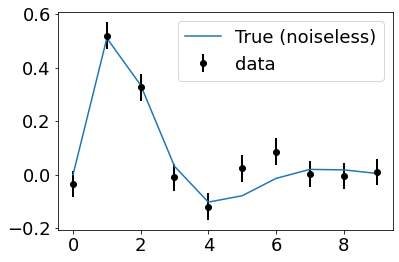

In [12]:
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data");
plt.plot(xin,y_true, label='True (noiseless)')
plt.legend();

### Descente de Gradient

In [13]:
## @jit
def gradient_descent_step(p, xi, yi, lr=0.1):
    return p - lr * jax.grad(loss_fun)(p, xi, yi)

In [14]:
def minimzer(loss_fun, x_data, y_data, par_init, method, verbose=True):
    p_cur = par_init
    new_loss=jnp.inf
    for t in range(5000):
   
        if (t % 100 == 0) and verbose:
            print(t, p_cur,new_loss)

        old_loss = new_loss
        new_p = method(p_cur, x_data,y_data)
        new_loss = loss_fun(new_p, x_data,y_data)

        if np.abs(new_loss-old_loss) < 1e-9:
            print(f"Converged after {t} epochs: p = {new_p}, loss = {new_loss}")
            break

        p_cur = new_p

    return p_cur

In [15]:
par_mini_GD = minimzer(loss_fun, x_data=xin, y_data=yin, par_init=jnp.array([0., 0.5]),
                    method=gradient_descent_step, verbose=True)

0 [0.  0.5] inf
100 [0.62048393 0.70750834] 0.008637562559042189
200 [0.59232543 0.93250246] 0.0033691784193686583
300 [0.54957041 1.04688945] 0.0017975857523135552
400 [0.53074669 1.08778781] 0.0015735323299857114
500 [0.52542832 1.09953584] 0.0015546792362664712
600 [0.52410865 1.10263342] 0.0015533842898307721
Converged after 633 epochs: p = [0.52394625 1.10302972], loss = 0.0015533297417048113


## Recommencez en decommentant "@jit" dans la celleule du `gradient_descent_step` : qu'observe-t'on?

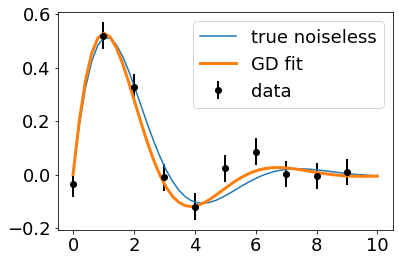

In [16]:
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data")
x_val = jnp.linspace(0.,10,50)
plt.plot(x_val,model(ptrue, x_val),label="true noiseless")
plt.plot(x_val,model(par_mini_GD, x_val) ,lw=3,label="GD fit")
plt.legend();

### Newton => hessien

In [17]:
gLoss = lambda p,xi,yi: jacfwd(loss_fun)(p,xi,yi)
hLoss = lambda p,xi,yi: jax.hessian(loss_fun)(p,xi,yi)

@jit
def oneStepNewton(p,xi,yi,lr=0.1):
    return p - lr*jnp.linalg.inv(hLoss(p,xi,yi)) @ gLoss(p,xi,yi)

In [18]:
par_mini_Newton = minimzer(loss_fun, x_data=xin, y_data=yin, par_init=jnp.array([0., 0.5]),
                    method=oneStepNewton, verbose=True)

0 [0.  0.5] inf
100 [0.07535076 0.00358029] 0.039375743398758295
Converged after 183 epochs: p = [0.52373613 1.10348083], loss = 0.0015532978650186742


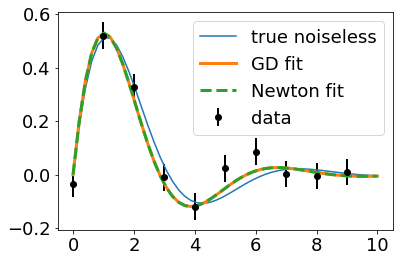

In [19]:
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data")
x_val = jnp.linspace(0.,10,50)
plt.plot(x_val,model(ptrue, x_val),label="true noiseless")
plt.plot(x_val,model(par_mini_GD, x_val) ,lw=3,label="GD fit")
plt.plot(x_val,model(par_mini_Newton, x_val),ls='--',lw=3,label="Newton fit")
plt.legend();

# Gradient/Vmap... par rapport à: tuples, lists, and dicts

In [20]:
def f(p,x):
    return p["a"]**2 + p["b"]*x

In [21]:
print(grad(f)({"a":3.,"b":1.},10))
print(vmap(f, in_axes=({"a": None, "b": 0},None))({"a":1.,"b":jnp.array([1.,2.,3.])},10))

{'a': DeviceArray(6., dtype=float64, weak_type=True), 'b': DeviceArray(10., dtype=float64, weak_type=True)}
[11. 21. 31.]


In [22]:
vmap(f, in_axes=({"a": None, "b": 0},None))({"a":3.,"b":jnp.array([1.,2.,3.])},10)

DeviceArray([19., 29., 39.], dtype=float64)

# idem avec un User PyTree

In [23]:
from jax.tree_util import register_pytree_node_class

@register_pytree_node_class
class Params:
    def __init__(self, a, b):
        self._a = a
        self._b = b

    def __repr__(self):
        return f"Params(x={self._a}, y={self._b})"

    @property
    def a(self):
        return self._a
    
    @property
    def b(self):
        return self._b

    def tree_flatten(self):
        children = (self._a, self._b)
        aux_data = None
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)

In [24]:
my_params = Params(3.,1.)
my_params

Params(x=3.0, y=1.0)

In [25]:
my_params.a, my_params.b

(3.0, 1.0)

In [26]:
def g(p,x):
    return (p.a)**2 + (p.b)*x

In [27]:
print(grad(g)(my_params,10))

Params(x=6.0, y=10.0)


In [28]:
print(vmap(g, in_axes=(Params(None, 0), None))(Params(3., jnp.array([1.,2.,3.])), 10))

[19. 29. 39.]


In [29]:
from jax.tree_util import tree_flatten, tree_unflatten
def show_example(structured):
    flat, tree = tree_flatten(structured)
    unflattened = tree_unflatten(tree, flat)
    print("structured={}\n  flat={}\n  tree={}\n  unflattened={}".format(
          structured, flat, tree, unflattened))

In [30]:
show_example(my_params)

structured=Params(x=3.0, y=1.0)
  flat=[3.0, 1.0]
  tree=PyTreeDef(CustomNode(<class '__main__.Params'>[None], [*, *]))
  unflattened=Params(x=3.0, y=1.0)


# EXTRA qd on aura pratiqué l'exemple de la fratale de Julia

In [31]:
def minimzer_bis(loss_fun, x_data, y_data, par_init, method, maxiter=5000, loss_diff=1e-9):

    cond_fun = lambda val: (val[1] < maxiter) & (jnp.abs(val[2]-val[3]) > loss_diff)
    
    @jit
    def body(val):
        p_cur    = val[0]
        old_loss = val[3]
        new_p = method(p_cur, x_data,y_data)
        new_loss = loss_fun(new_p, x_data,y_data)
        return [new_p, val[1]+1,  old_loss, new_loss]
        

    val = [par_init, 0.,0.,jnp.inf]   # on peut faire avec des Tuples, a accorder avec le return de body
    val = jax.lax.while_loop(cond_fun,body,val)

    return val

In [32]:
param, n_iter, loss,_ = minimzer_bis(loss_fun, x_data=xin, y_data=yin, par_init=jnp.array([0., 0.5]),
                    method=gradient_descent_step)

In [33]:
print(f"{n_iter} epochs: p = {param}, loss = {loss:.2e}")

634.0 epochs: p = [0.52394625 1.10302972], loss = 1.55e-03
